## Install dependencies and packages

In [1]:
!pip install -r requirements.txt
!pip install -r requirements_gpu.txt

## Import library

In [2]:
from transformers import ViTImageProcessor, ViTModel
from qdrant_client import QdrantClient
from qdrant_client.http import models
from datasets import load_dataset
import numpy as np
import torch
import pandas as pd
import os
from PIL import Image

## Setup the vector store

In [3]:
# Create a local Qdrant vector store
client = QdrantClient(path="qdrant_db")
my_collection = "image_collection"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=384, distance=models.Distance.COSINE)
)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_199136\2363396610.py:4: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

## Load the model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = ViTImageProcessor.from_pretrained('facebook/dino-vits16')
model = ViTModel.from_pretrained('facebook/dino-vits16').to(device)

C:\Users\ASUS\anaconda3\envs\face\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preprocess the images in the photos folder and load into a dataframe

In [5]:
image_file = []
image_name =[]

for file in os.listdir("photos"):
    if file.endswith(".jpg"):
        image_name.append(file.split(".")[0])
        image_file.append(Image.open(os.path.join("photos", file)))

df = pd.DataFrame({"Image": image_file, "Name": image_name})
descriptions = df['Name'].tolist()
print(descriptions)

['img_1', 'img_2', 'img_3']


## Generate embeddings with ViTs

In [6]:
final_embeddings = []
for item in df['Image'].values.tolist():
    inputs = processor(images=item, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs).last_hidden_state.mean(dim=1).cpu().numpy()
    final_embeddings.append(outputs)

## Save the embeddings

In [7]:
np.save("vectors", np.array(final_embeddings), allow_pickle=False)

## Generate the metadata

In [8]:
payload = []
for i in range(df.shape[0]):
    payload.append({"image_id": i,
                    "name": df.iloc[i]['Name']})

ids = list(range(df.shape[0]))
embeddings = np.load("vectors.npy").tolist()

## Load the embeddings to the vector store

In [9]:
for i in range(0, df.shape[0]):
    client.upsert(
        collection_name=my_collection,
        points=models.Batch(
            ids=[ids[i]],
            vectors=embeddings[i],
            payloads=[payload[i]]
        )
    )

In [10]:
#check if the update is successful
client.count(
    collection_name=my_collection,
    exact=True,
)

CountResult(count=3)

In [11]:
#To visually inspect the collection we just created, we can scroll through our vectors with the client.scroll() method.
client.scroll(
    collection_name=my_collection,
    limit=10
)

([Record(id=0, payload={'image_id': 0, 'name': 'img_1'}, vector=None, shard_key=None),
  Record(id=1, payload={'image_id': 1, 'name': 'img_2'}, vector=None, shard_key=None),
  Record(id=2, payload={'image_id': 2, 'name': 'img_3'}, vector=None, shard_key=None)],
 None)

## Search for an image/photo from the data store

In [12]:
files_list = [os.path.join("photos", f) for f in os.listdir("photos")]

In [13]:
def see_images(results, top_k=2):
    for i in range(top_k):
        image_id = results[i].payload['image_id']
        name    = results[i].payload['name']
        score = results[i].score
        image = Image.open(files_list[image_id])

        print(f"Result #{i+1}: {name} was diagnosed with {score * 100} confidence")
        print(f"This image score was {score}")
        display(image)
        print("-" * 50)
        print()

Result #1: img_1 was diagnosed with 90.39981778228766 confidence
This image score was 0.9039981778228765


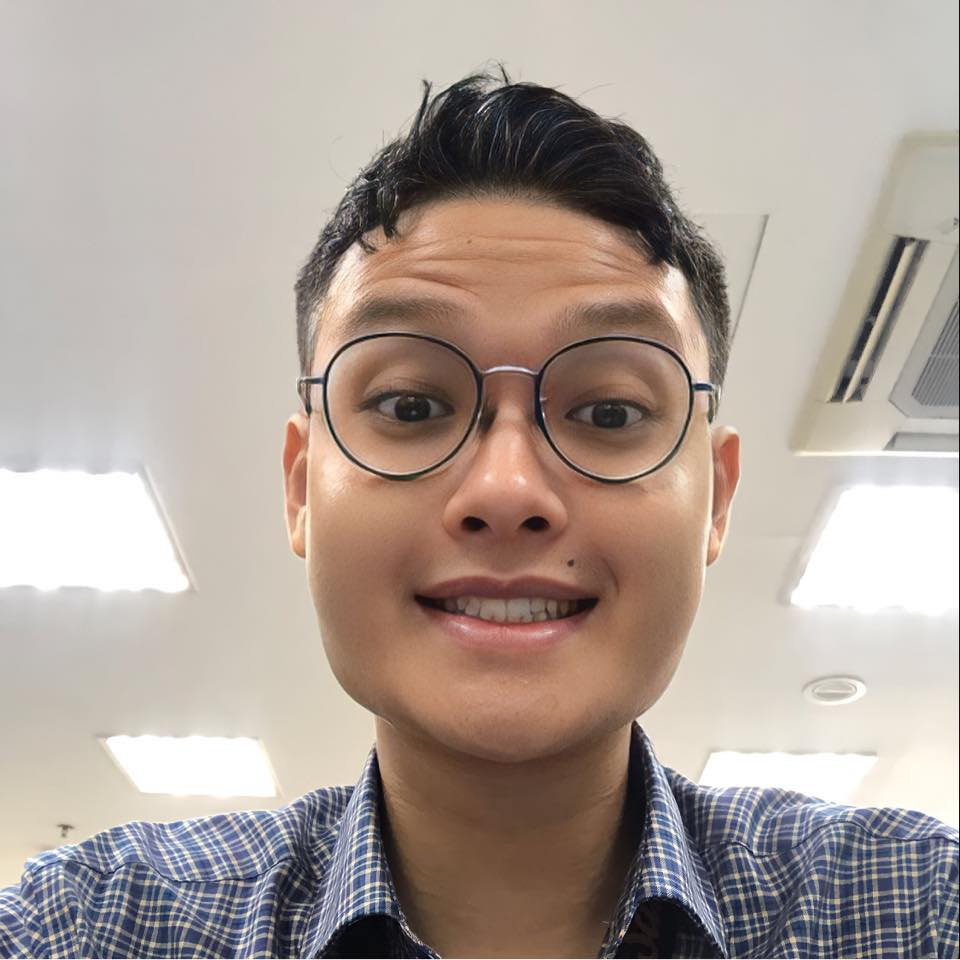

--------------------------------------------------



In [14]:
img = Image.open("test.jpg")
inputs = processor(images=img, return_tensors="pt").to(device)
one_embedding = model(**inputs).last_hidden_state

results = client.search(
    collection_name=my_collection,
    query_vector=one_embedding.mean(dim=1)[0].tolist(),
    limit=5,
    with_payload=True
)
see_images(results, top_k=1)